In [23]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import cv2
from tqdm import tqdm_notebook as tqdm

In [0]:
# path : /content/gdrive/My Drive/Datasets/Landscapes 
path = "/content/gdrive/My Drive/Datasets/Landscapes_snapshots"

In [0]:
%%capture
image_list = []
import os
for dirname, _, filename in os.walk(path) :
  for files in filename :
    i =  os.path.join(dirname, files)
    print(i)
    image_list.append(i)

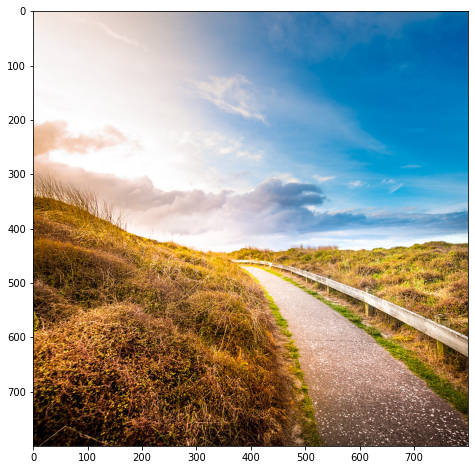

In [27]:
sample_image = cv2.imread("/content/gdrive/My Drive/Datasets/Landscapes_snapshots/landscapes/00000006.jpg")
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (12, 8))
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)

### Note : 

While augmenting/changing colorspace in tensorflow the output was a 3-D tensor with the third dimension as 1(different from the openCV implementation). Hence, tensor of shape (nx,ny,1) must be squeezed or sliced into a 2D array. This is done using squeeze() method in tensorflow.

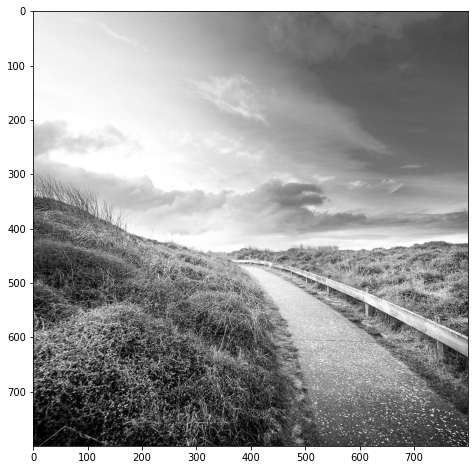

In [28]:
plt.figure(figsize = (12, 8))
gray = tf.image.rgb_to_grayscale(sample_image)
plt.imshow(tf.squeeze(gray), cmap = "gray")
plt.grid(False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


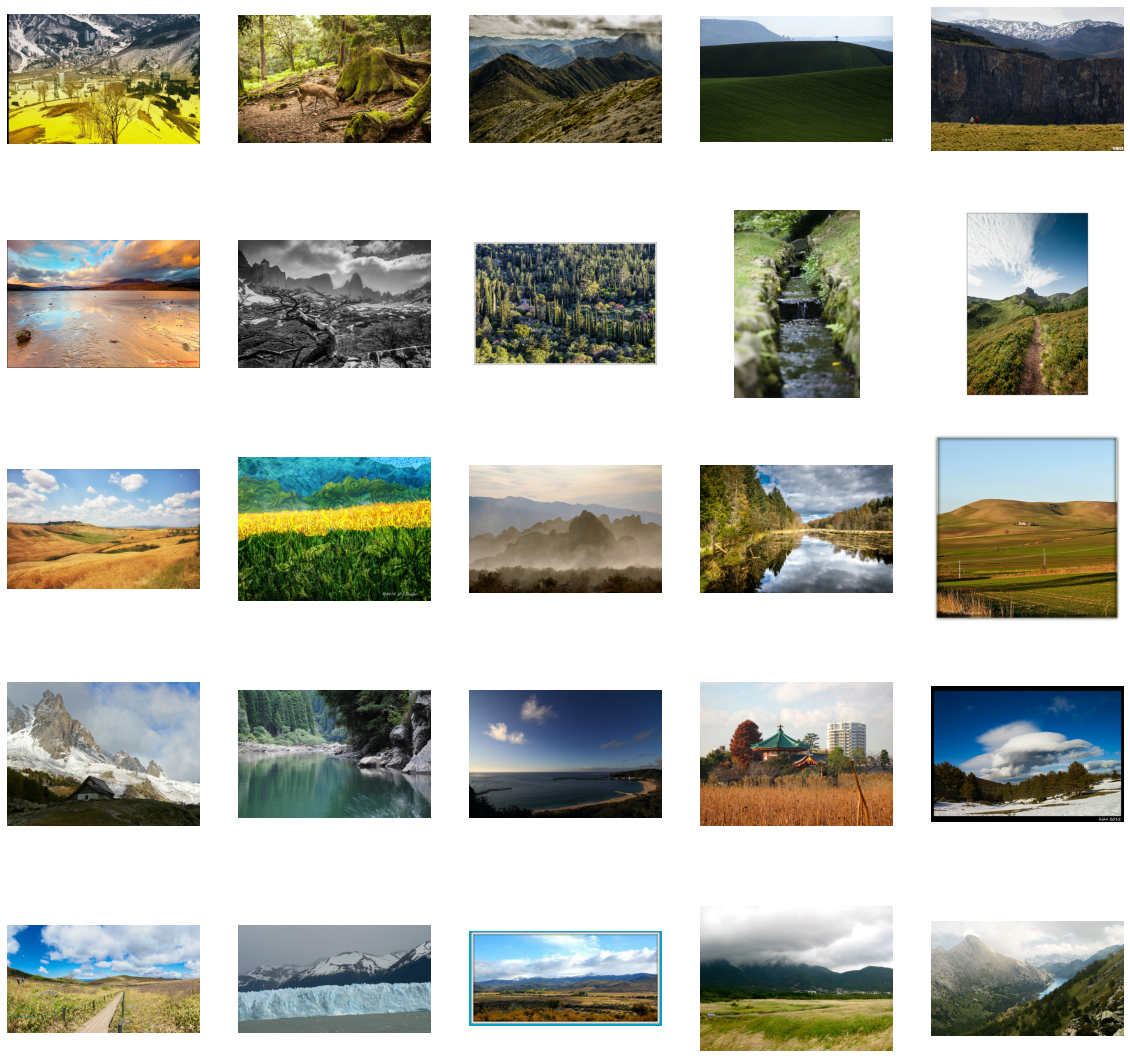

In [29]:
plt.figure(figsize = (20, 20))
for i in tqdm(range(25)) : 
    ax = plt.subplot(5, 5, i + 1)
    image_path = image_list[i]
    image_string=tf.io.read_file(image_path)
    image=tf.image.decode_jpeg(image_string,channels=3)
    plt.imshow(image, cmap = "gray")
    plt.axis("off")
    plt.grid(False)

In [30]:
gray.shape

TensorShape([800, 800, 1])

In [31]:
len(image_list)

4332

In [32]:
print("Number of images = ", len(image_list))
print("shape of an image ", sample_image.shape) # this is just to get the idea about image quality. Resize() function will be applied later to bring all of them to same dimensions.

Number of images =  4332
shape of an image  (800, 800, 3)


In [0]:
IMG_SIZE = (600, 600)
BATCH_SIZE = 32

### Tensorflow functions used : 



* #### tf.data.Dataset.from_tensor_slices() ->   
Creates a Dataset whose elements are slices of the given tensors. The given tensors are sliced along their first dimension. This operation preserves the structure of the input tensors, removing the first dimension of each tensor and using it as the dataset dimension. All input tensors must have the same size in their first dimensions.

* #### tf.data.Dataset.from_tensor_slices.map() ->
This transformation applies map_func to each element of this dataset, and returns a new dataset containing the transformed elements, in the same order as they appeared in the input. map_func can be used to change both the values and the structure of a dataset's elements. For example, adding 1 to each element, or projecting a subset of element components.

* #### tf.data.Dataset.from_tensor_slices.prefetch() ->
Creates a Dataset that prefetches elements from this dataset. Most dataset input pipelines should end with a call to prefetch. This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.

* #### tf.data.Dataset.from_tensor_slices.batch() -> 
Combines consecutive elements of this dataset into batches.

* #### tf.data.Dataset.from_tensor_slices.batch() ->
Randomly shuffles the elements of this dataset. This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer,replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.
For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then shuffle will initially select a random element from only the first 1,000 elements in the buffer. Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.

In [0]:
def get_image(path_to_image) : 
  image = tf.io.read_file(path_to_image)
  image = tf.image.decode_jpeg(image, channels = 3)
  image = tf.image.resize(image, IMG_SIZE)
  return image

In [0]:
def rgb_to_grayscale(image):
    gray = tf.image.rgb_to_grayscale(image)
    gray = tf.math.divide(gray,255)
    return gray

In [0]:
def create_dataset(file_list) : 
  tensor_slices = tf.data.Dataset.from_tensor_slices(file_list) 
  images_rgb = tensor_slices.map(get_image)
  images_gray = images_rgb.map(rgb_to_grayscale)
  zipped_tensor_slices = tf.data.Dataset.zip((images_gray, images_rgb))
  zipped_tensor_slices = zipped_tensor_slices.shuffle(50)
  zipped_tensor_slices = zipped_tensor_slices.batch(BATCH_SIZE)
  zipped_tensor_slices = zipped_tensor_slices.prefetch(tf.data.experimental.AUTOTUNE)
  return zipped_tensor_slices

In [0]:
train = create_dataset(image_list[:int(len(image_list)*0.9)])
val = create_dataset(image_list[int(len(image_list) * 0.9) : ])

In [38]:
type(train), type(val)

(tensorflow.python.data.ops.dataset_ops.PrefetchDataset,
 tensorflow.python.data.ops.dataset_ops.PrefetchDataset)